1_data_preprocessing.ipynb

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Drop uninformative columns
df.drop(["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], axis=1, inplace=True)

# Encode target
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

# Encode categorical features
categoricals = df.select_dtypes("object").columns
le = LabelEncoder()
for col in categoricals:
    df[col] = le.fit_transform(df[col])

# Save cleaned data for Power BI
df.to_csv("3_powerbi_export.csv", index=False)
print("✅ Cleaned and saved for Power BI!")


✅ Cleaned and saved for Power BI!


2_modeling.ipynb

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.67      0.15      0.25        39

    accuracy                           0.88       294
   macro avg       0.78      0.57      0.59       294
weighted avg       0.86      0.88      0.84       294

Decision Tree:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       255
           1       0.27      0.15      0.20        39

    accuracy                           0.83       294
   macro avg       0.58      0.55      0.55       294
weighted avg       0.80      0.83      0.81       294



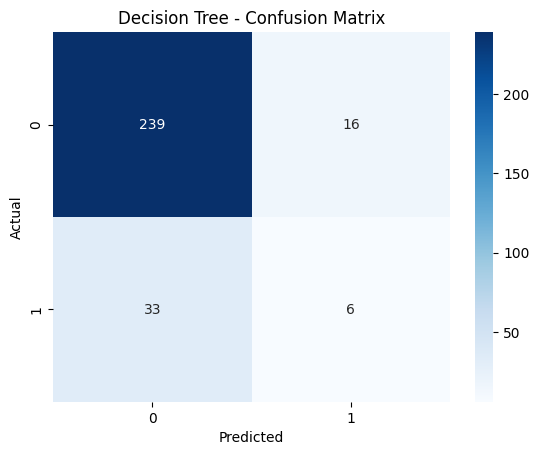

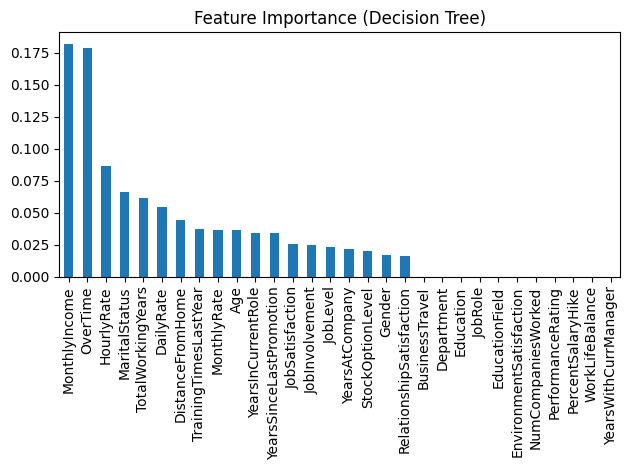

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv("3_powerbi_export.csv")
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Confusion Matrix for DT
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Show top features (Decision Tree)
importance = pd.Series(dt.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind="bar", title="Feature Importance (Decision Tree)")
plt.tight_layout()
plt.show()


3_shap_explainability.ipynb

In [12]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("3_powerbi_export.csv")


# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# --------------------
# SHAP Explainability
# --------------------

# Use SHAP's universal explainer (newer, reliable API)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot 1: SHAP Beeswarm summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_beeswarm.png", bbox_inches="tight")
plt.clf()

# Plot 2: SHAP Bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("shap_summary_bar.png", bbox_inches="tight")
plt.clf()

print("✅ SHAP explainability plots saved as:")
print("   - shap_summary_beeswarm.png")
print("   - shap_summary_bar.png")


Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       255
           1       0.83      0.13      0.22        39

    accuracy                           0.88       294
   macro avg       0.86      0.56      0.58       294
weighted avg       0.88      0.88      0.84       294

Accuracy Score: 0.8809523809523809
✅ SHAP explainability plots saved as:
   - shap_summary_beeswarm.png
   - shap_summary_bar.png


<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>